# Introduction to Python GPU Programming with Numba and NumbaPro

In [3]:
# Misc. import
from __future__ import print_function
from IPython.display import Image 
%matplotlib inline

# Numba
* Opensource BSD license
* Basic CUDA GPU JIT compilation
* OpenCL support coming

In [5]:
import numba
print("numba", numba.__version__)

numba 0.22.1


# Accelerate
* Commercial
* Contains CUDA library bindings: cuRAND, cuBLAS, cuFFT, cuSparse

In [6]:
import accelerate
print("accelerate", accelerate.__version__)

accelerate 2.0.0


# The CUDA GPU

- A massively parallel processor (many cores)
    - 100 threads, 1,000 threads, and more
- optimized for data throughput
    - Simple (shallow) cache hierarchy
    - Best with manual caching!
    - Cache memory is called shared memory and it is addressable
- CPU is latency optimized
    - Deep cache hierarchy
    - L1, L2, L3 caches
- GPU execution model is different
- GPU forces you to think and program *in parallel*

In [8]:
# Get all the imports we need
import numba.cuda
import numpy as np
import math

my_gpu = numba.cuda.get_current_device()
print("Running on GPU:", my_gpu.name)
cores_per_capability = {
    1: 8,
    2: 32,
    3: 192,
    5: 128
}
cc = my_gpu.compute_capability
print("Compute capability: ", "%d.%d" % cc, "(Numba requires >= 2.0)")
majorcc = cc[0]
print("Number of streaming multiprocessor:", my_gpu.MULTIPROCESSOR_COUNT)
cores_per_multiprocessor = cores_per_capability[majorcc]
print("Number of cores per mutliprocessor:", cores_per_multiprocessor)
total_cores = cores_per_multiprocessor * my_gpu.MULTIPROCESSOR_COUNT
print("Number of cores on GPU:", total_cores)

Running on GPU: b'GeForce GTX 970'
Compute capability:  5.2 (Numba requires >= 2.0)
Number of streaming multiprocessor: 13
Number of cores per mutliprocessor: 128
Number of cores on GPU: 1664


# High-level Array-Oriented Style

- Use NumPy array as a unit of computation
- Use NumPy universal function (ufunc) as an abstraction of computation and scheduling
- ufuncs are elementwise functions
- If you use NumPy, you are using ufuncs

In [10]:
print(np.sin, "is of type", type(np.sin))
print(np.add, "is of type", type(np.add))

<ufunc 'sin'> is of type <class 'numpy.ufunc'>
<ufunc 'add'> is of type <class 'numpy.ufunc'>


# Vectorize

- generate a ufunc from a python function
- converts scalar function to elementwise array function
- Numba provides CPU and GPU support

In [11]:
# CPU version
@numba.vectorize(['float32(float32, float32)',
                  'float64(float64, float64)'], target='cpu')
def cpu_sincos(x, y):
    return math.sin(x) * math.cos(y)

# CUDA version
@numba.vectorize(['float32(float32, float32)',
                     'float64(float64, float64)'], target='cuda')
def gpu_sincos(x, y):
    return math.sin(x) * math.cos(y)

```
@numba.vectorize(<list of signatures>, target=<'cpu', 'gpu'>)
```

- A ufunc can be overloaded to work on multiple type signatures


### Test it out

- 2 input arrays
- 1 output array
- 1 million doubles (8 MB) per array
- Total 24 MB of data

In [12]:
# Generate data
n = 1000000
x = np.linspace(0, np.pi, n)
y = np.linspace(0, np.pi, n)

# Check result
np_ans = np.sin(x) * np.cos(y)
nb_cpu_ans = cpu_sincos(x, y)
nb_gpu_ans = gpu_sincos(x, y)

print("CPU vectorize correct: ", np.allclose(nb_cpu_ans, np_ans))
print("GPU vectorize correct: ", np.allclose(nb_gpu_ans, np_ans))

CPU vectorize correct:  True
GPU vectorize correct:  True


## Benchmark

In [15]:
print("NumPy")
%timeit np.sin(x) * np.cos(y)

print("CPU vectorize")
%timeit cpu_sincos(x, y)

print("GPU vectorize")
%timeit gpu_sincos(x, y)

# Optional cleanup 
del x, y

NumPy
10 loops, best of 3: 44 ms per loop
CPU vectorize
10 loops, best of 3: 37.7 ms per loop
GPU vectorize
100 loops, best of 3: 4.81 ms per loop


- CPU vectorize time is similar to pure NumPy time because ``sin()`` and ``cos()`` calls dominate the time.
- GPU vectorize is a lot faster



## Behind the scence




### Automatic memory transfer

- NumPy arrays are automatically transferred
    - CPU -> GPU
    - GPU -> CPU


### Automatic work scheduling

- The work is distributed the across all threads on the GPU
- The GPU hardware handles the scheduling



### Automatic GPU memory management

- GPU memory is tied to object lifetime
- freed automatically

# Another Vectorize Example

In [16]:
@numba.vectorize(['float32(float32, float32, float32, float32)'])
def cpu_powers(p, q, r, s):
    return math.sqrt(p ** 2 + q ** 3 + r ** 4 + s ** 5)

@numba.vectorize(['float32(float32, float32, float32, float32)'], target='cuda')
def gpu_powers(p, q, r, s):
    return math.sqrt(p ** 2 + q ** 3 + r ** 4 + s ** 5)

In [18]:
# Generate data
n = 5000000
p = np.random.random(n).astype(np.float32)
q = np.random.random(n).astype(np.float32)
r = np.random.random(n).astype(np.float32)
s = np.random.random(n).astype(np.float32)

# Check results
np_ans = np.sqrt(p ** 2 + q ** 3 + r ** 4 + s ** 5)
cpu_ans = cpu_powers(p, q, r, s)
gpu_ans = gpu_powers(p, q, r, s)
print("CPU vectorize correct", np.allclose(np_ans, cpu_ans))
print("GPU vectorize correct", np.allclose(np_ans, gpu_ans))

CPU vectorize correct True
GPU vectorize correct True


## Benchmark

In [19]:
print("NumPy")
%timeit np.sqrt(p ** 2 + q ** 3 + r ** 4 + s ** 5)
print("CPU vectorize")
%timeit cpu_powers(p, q, r, s)
print("GPU vectorize")
%timeit gpu_powers(p, q, r, s)

# Optional cleanup 
del p, q, r, s

NumPy
1 loops, best of 3: 1e+03 ms per loop
CPU vectorize
10 loops, best of 3: 20.8 ms per loop
GPU vectorize
100 loops, best of 3: 16.4 ms per loop


* NumPy is slower than CPU vectorize (likely due to allocation of temporaries)
* CPU version is slower than GPU version because of multiple cores running (even though copying to card and back is costly)

# Generalized Universal Function (guvectorize)

- Vectorize is limited to scalar arguments in the core function
- GUVectorize accepts array arguments

In [20]:
@numba.guvectorize(['void(float32[:,:], float32[:,:], float32[:,:])'],
                      '(m, n),(n, p)->(m, p)', target='cuda')
def batch_matrix_mult(a, b, c):
    for i in range(c.shape[0]):
        for j in range(c.shape[1]):
            tmp = 0
            for n in range(a.shape[1]):
                 tmp += a[i, n] * b[n, j]
            c[i, j] = tmp

```
@numba.guvectorize(<list of function signatures>, <a string to desc the shape signature>, target=<'cpu', 'cuda'>)
```

In [24]:
a = np.arange(1.0, 10.0, dtype=np.float32).reshape(3,3)
b = np.arange(1.0, 10.0, dtype=np.float32).reshape(3,3)

# Use the builtin matrix_multiply in NumPy for CPU test
import numpy.core.umath_tests as ut

# Check result
print('NumPy result')
np_ans = ut.matrix_multiply(a, b)
print(np_ans)

print('Numba GPU result')
gpu_ans = batch_matrix_mult(a, b)
print(gpu_ans)

assert np.allclose(np_ans, gpu_ans)


NumPy result
[[  30.   36.   42.]
 [  66.   81.   96.]
 [ 102.  126.  150.]]
Numba GPU result
[[  30.   36.   42.]
 [  66.   81.   96.]
 [ 102.  126.  150.]]


### Test it out

- batch multiply two 4 million 2x2 matrices 

In [25]:
n = 4000000
dim = 2
a = np.random.random(n * dim * dim).astype(np.float32).reshape(n, dim, dim)
b = np.random.random(n * dim * dim).astype(np.float32).reshape(n, dim, dim)

print('NumPy time')
%timeit ut.matrix_multiply(a, b)

print('Numba GPU time')
%timeit batch_matrix_mult(a, b)

NumPy time
10 loops, best of 3: 81.3 ms per loop
Numba GPU time
10 loops, best of 3: 87.9 ms per loop


- GPU time seems to be similar to CPU time



## Manually Transfer the data to the GPU

- This will let us see the actual compute time without the CPU<->GPU transfer

In [26]:
dc = numba.cuda.device_array_like(a)
da = numba.cuda.to_device(a)
db = numba.cuda.to_device(b)

* ```numba.cuda.device_array_like``` allocate without initialization with the type and shape of another array.
    * similar to ```numpy.empty_like(a)```
* ```numba.cuda.to_device``` create a GPU copy of the CPU array



## Pure compute time on the GPU

In [27]:
def check_pure_compute_time(da, db, dc):
    batch_matrix_mult(da, db, out=dc)
    numba.cuda.synchronize()   # ensure the call has completed
    
%timeit check_pure_compute_time(da, db, dc)
del da, db, dc

100 loops, best of 3: 3.35 ms per loop


* Actual compute time is **a lot faster**
* PCI-express transfer overhead

#### Tips
If you have a sequence of ufuncs to apply, pin the data on the GPU by manual transfer

# Accelerate CUDA Libraries Bindings

- Access to CUDA libraries 
- Work seamless with NumPy
    - auto memory transfer
    - managed memory

- cuBLAS: CUDA version of BLAS
- cuSparse: CUDA sparse matrix support
- cuFFT: FFT on CUDA
- cuRAND: random number generation on CUDA

# An Example with CUDA Libs
## Convolution on the GPU

#### Import cuFFT

In [28]:
import accelerate.cuda.fft as cufft

#### Misc. imports

In [29]:
from scipy.signal import fftconvolve
from scipy import misc, ndimage
from matplotlib import pyplot as plt
from timeit import default_timer as timer

#### Build elementwise complex array multiplication CUDA function

In [30]:
@numba.vectorize(['complex64(complex64, complex64)'], target='cuda')
def vmult(a, b):
    return a * b

#### Prepare image and filter

In [31]:
image = misc.face(gray=True).astype(np.float32)

laplacian_pts = '''
-4 -1 0 -1 -4
-1 2 3 2 -1
0 3 4 3 0
-1 2 3 2 -1
-4 -1 0 -1 -4
'''.split()

laplacian = np.array(laplacian_pts, dtype=np.float32).reshape(5, 5)

response = np.zeros_like(image)
response[:5, :5] = laplacian

print("Image size: %s" % (image.shape,))

Image size: (768, 1024)


#### Convolution on the CPU

In [33]:
ts = timer()  # Start Timer
cvimage_cpu = fftconvolve(image, laplacian, mode='same')
te = timer()  # Stop Timer
print('CPU: %.2fs' % (te - ts))

CPU: 0.05s


#### Convolution on the GPU

In [34]:
image_complex = image.astype(np.complex64)
response_complex = response.astype(np.complex64)

In [35]:
# Trigger initialization the cuFFT system.
# This takes significant time for small dataset.
# We should not be including the time wasted here
cufft.FFTPlan(shape=image.shape, itype=np.complex64, otype=np.complex64)

In [37]:
ts = timer()     # Start timer

d_image_complex = numba.cuda.to_device(image_complex)
d_response_complex = numba.cuda.to_device(response_complex)

# Forward FFT
cufft.fft_inplace(d_image_complex)
cufft.fft_inplace(d_response_complex)

# Multiply the image with teh filter
vmult(d_image_complex, d_response_complex, out=d_image_complex)

# Inverse FFT
cufft.ifft_inplace(d_image_complex)

cvimage_gpu = d_image_complex.copy_to_host().real / np.prod(image.shape)

te = timer()   # Stop timer

print('GPU: %.2fs' % (te - ts))

GPU: 0.01s


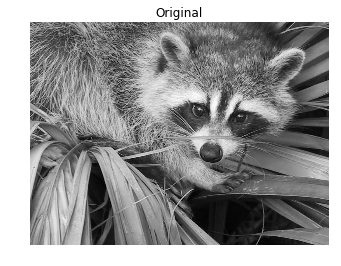

In [38]:
plt.title('Original')
plt.imshow(image, cmap=plt.cm.gray)
plt.axis('off')
plt.show()

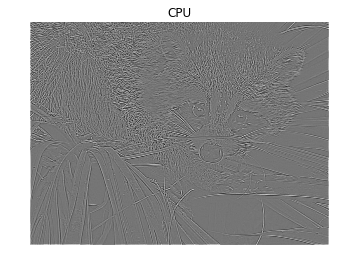

In [39]:
plt.title('CPU')
plt.imshow(cvimage_cpu, cmap=plt.cm.gray)
plt.axis('off')
plt.show()

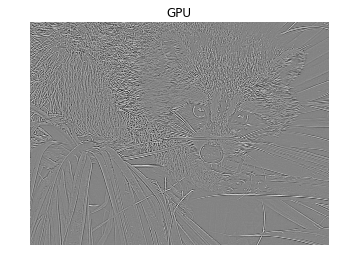

In [40]:
plt.title('GPU')
plt.imshow(cvimage_gpu, cmap=plt.cm.gray)
plt.axis('off')
plt.show()

-----

# Low-Level Approach: @numba.cuda.jit

- Numba can generate CUDA functions with the `@jit` decorator
- Decorated function follows CUDA execution model 

## CUDA Execution Model

- Kernel functions
    - visible to the host CPU
    - cannot return any value
        - use output argument
    - associates to a _grid_
- Grid
    - a group of blocks
    - 1D, 2D, 3D
- Blocks
    - a group of threads
    - 1D, 2D, 3D  
- Every thread executes the same kernel
    - thread can use the grid, block, thread coordinate system to determine its ID

In [41]:
Image(url='http://docs.nvidia.com/cuda/cuda-c-programming-guide/graphics/grid-of-thread-blocks.png')

## Compiling a CUDA Kernel

In [42]:
from numba import cuda

@numba.cuda.jit("void(float32[:], float32[:], float32[:])")
def vadd(arr_a, arr_b, arr_out):
    tx = cuda.threadIdx.x
    bx = cuda.blockIdx.x
    bw = cuda.blockDim.x    # number of threads per block
    i = tx + bx * bw
    if i >= arr_out.size:
        return
    arr_out[i] = arr_a[i] + arr_b[i]

### Code Explained

#### Define a CUDA kernel with three 1D float32 arrays as args

```
@numba.cuda.jit("void(float32[:], float32[:], float32[:])")
def vadd(arr_a, arr_b, arr_out):
```

#### Map thread, block coordinate to global position
```
    tx = cuda.threadIdx.x   # thread label (along x dimension)
    bx = cuda.blockIdx.x    # block label (along x dimension)
    bw = cuda.blockDim.x    # number of threads in each block (along x dimension)
    i = tx + bx * bw        # flattened linear address for each thread
```
or simplified to:
```
    i = cuda.grid(1)
``` 

#### Ensure global position is within array size

```
    if i >= arr_out.size:
        return
```

#### The actual work

```
    arr_out[i] = arr_a[i] + arr_b[i]
```

## Launch kernel

#### Prepare data

In [43]:
n = 100
a = np.arange(n, dtype=np.float32)
b = np.arange(n, dtype=np.float32)
c = np.empty_like(a)                 # Must prepare the output array to hold the result


#### Calculate thread, block count

- thread count is set to **warp size** of the GPU
    - Warp size is similar to SIMD vector width on the CPU
    - **performance tips**: set thread count to multiple of warp size
- block count is ceil(n/thread_ct)

**Note:**
This will launch more threads than there are elements in the array

In [44]:
thread_ct = my_gpu.WARP_SIZE
block_ct = int(math.ceil(float(n) / thread_ct))

print("Threads per block:", thread_ct)
print("Block per grid:", block_ct)

Threads per block: 32
Block per grid: 4


#### Launch kernel

Kernel function object uses the ``__getitem__`` (indexing notation) to configure the grid and block dimensions.

```
    kernel_function[griddim, blockdim](*args)
```

- **griddim**
    - Number of blocks per grid (grid dimension)
    - type: int for 1d or 1,2,3-tuple of ints for 1d, 2d, or 3d respectively

- **blockdim**: 
    - Number of threads per block (blockdim dimension)
    - type: int for 1d or 1,2,3-tuple of ints for 1d, 2d, or 3d respectively


In [45]:
vadd[block_ct, thread_ct](a, b, c)    # Last argument is the output array in this case
print(c)

[   0.    2.    4.    6.    8.   10.   12.   14.   16.   18.   20.   22.
   24.   26.   28.   30.   32.   34.   36.   38.   40.   42.   44.   46.
   48.   50.   52.   54.   56.   58.   60.   62.   64.   66.   68.   70.
   72.   74.   76.   78.   80.   82.   84.   86.   88.   90.   92.   94.
   96.   98.  100.  102.  104.  106.  108.  110.  112.  114.  116.  118.
  120.  122.  124.  126.  128.  130.  132.  134.  136.  138.  140.  142.
  144.  146.  148.  150.  152.  154.  156.  158.  160.  162.  164.  166.
  168.  170.  172.  174.  176.  178.  180.  182.  184.  186.  188.  190.
  192.  194.  196.  198.]


# Example: Matrix Matrix Multiplication

- Show manual caching with shared memory
- Not the best matrix matrix multiplication implementation

#### Prepare constants

In [46]:
from numba import float32

bpg = 150
tpb = 32
n = bpg * tpb
shared_mem_size = (tpb, tpb)
griddim = bpg, bpg
blockdim = tpb, tpb

#### Naive version

In [47]:
Image(url="http://docs.nvidia.com/cuda/cuda-c-programming-guide/graphics/matrix-multiplication-without-shared-memory.png")

In [48]:
@numba.cuda.jit("void(float32[:,:], float32[:,:], float32[:,:])")
def naive_matrix_mult(A, B, C):
    x, y = cuda.grid(2)
    if x >= n or y >= n:
        return

    C[y, x] = 0
    for i in range(n):
        C[y, x] += A[y, i] * B[i, x]


#### Optimized version (shared memory + blocking)

In [49]:
Image(url="http://docs.nvidia.com/cuda/cuda-c-programming-guide/graphics/matrix-multiplication-with-shared-memory.png")

In [50]:
@numba.cuda.jit("void(float32[:,:], float32[:,:], float32[:,:])")
def optimized_matrix_mult(A, B, C):
    # Declare shared memory
    sA = cuda.shared.array(shape=shared_mem_size, dtype=float32)
    sB = cuda.shared.array(shape=shared_mem_size, dtype=float32)
    
    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    x, y = cuda.grid(2)

    acc = 0
    for i in range(bpg):
        if x < n and y < n:
            # Prefill cache
            sA[ty, tx] = A[y, tx + i * tpb]
            sB[ty, tx] = B[ty + i * tpb, x]

        # Synchronize all threads in the block
        cuda.syncthreads()

        if x < n and y < n:
            # Compute product
            for j in range(tpb):
                acc += sA[ty, j] * sB[j, tx]

        # Wait until all threads finish the computation
        cuda.syncthreads()

    if x < n and y < n:
        C[y, x] = acc

#### Prepare data

In [51]:
# Prepare data on the CPU
A = np.array(np.random.random((n, n)), dtype=np.float32)
B = np.array(np.random.random((n, n)), dtype=np.float32)

print("N = %d x %d" % (n, n))

# Prepare data on the GPU
dA = cuda.to_device(A)
dB = cuda.to_device(B)
dC = cuda.device_array_like(A)

N = 4800 x 4800


#### Benchmark

In [52]:
# Time the unoptimized version
s = timer()
naive_matrix_mult[griddim, blockdim](dA, dB, dC)
numba.cuda.synchronize()
e = timer()
unopt_ans = dC.copy_to_host()
tcuda_unopt = e - s

# Time the optimized version
s = timer()
optimized_matrix_mult[griddim, blockdim](dA, dB, dC)
numba.cuda.synchronize()
e = timer()
opt_ans = dC.copy_to_host()
tcuda_opt = e - s

#### Result

In [53]:
assert np.allclose(unopt_ans, opt_ans)
print("Without shared memory:", "%.2f" % tcuda_unopt, "s")
print("With shared memory:", "%.2f" % tcuda_opt, "s")

Without shared memory: 3.75 s
With shared memory: 4.23 s


# Summary

- Numba
    - opensource low-level GPU support
    - CUDA kernel ``@numba.cuda.jit``
    - vectorize ``@numba.vectorize``
    - guvectorize ``@numba.guvectorize``
- Accelerate
    - CUDA libraries ``accelerate.cuda.*``
